# Modelling Kepler lightcurves - Toolbox

This notebook contains tools you will need to model your lightcurve, it is not a guided notebook like previous notebook, but instead introduces you to tools you'll need to find your planet properties. I recommend copying relevant code across to a separate notbook to do your fitting.

#### In this notebook, you find tools to:

$\bullet$ reduce the lightcurve to create a single corrected lightcurve, this will need to be included in your submission. 

$\bullet$ create a periodogram to identify the periods of different planets

$\bullet$ fit the depth of a specific transit or your choosing, results with errors need to be included in the submission

$\bullet$ fold the lightcurve for the same planet, finished stacked transits needs to be included in your submission

In [1]:
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy
from scipy import interpolate
from scipy.optimize import curve_fit
import LightCurveSimulator

## Writing data to file

In this section, you will be manipulating datasets, you might want to write the data to file for future use. There are two ways of doing this. Python file manipulation and numpy.

##### Python File manipulation. 
The most general way for working with files. See [official documentation](https://docs.python.org/3/library/functions.html#open). Check out [strong formatting here](https://www.learnpython.org/en/String_Formatting).

In [2]:
## Lets open a file, the first argument is the filename, the second is the mode 'r' for read-only, 'w' for write
filehandle = open('STUPIDTESTFILE', 'w')
filehandle.write('Hello world \n') #'\n' adds a line break
filehandle.write('%s, %s, %s \n' %(1,2,3)) #
filehandle.write('This is what happens if you do not add a line break')
filehandle.write('14, 15, 16')
filehandle.close()

In [3]:
#### Have a look at the file in your main tab. You can open this file as follows.
filehandle = open('STUPIDTESTFILE', 'r')
filehandle.readlines()

['Hello world \n',
 '1, 2, 3 \n',
 'This is what happens if you do not add a line break14, 15, 16']

#### numpy file manipulation
You can get more specialized file manipulation with [numpy.loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) and [numpy.savetxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html). This function works specifically for arrays, if you have more general data, the method above works better.

In [4]:
#### Lets say we have an array and want to write it to file.
t = [1,2,3,4,5,6,7,8,9,10]
flux = [1,1,0.9,0.9,0.9, 0.9,1,1,1 ,1]
numpy.savetxt('NUMPYTESTFILE', numpy.array([t, flux]).transpose(), delimiter=',') #delimiter sets the sign used between fields, ',' is a commonly used one
#transpose turns this into a standatd two column file, have a look in your browser

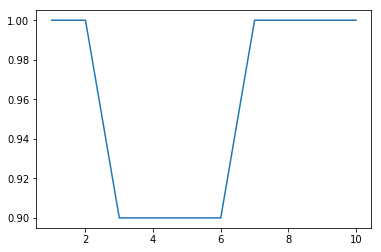

In [5]:
# We can now load the same file
testdata = numpy.loadtxt('NUMPYTESTFILE', delimiter=',') ## rememberto give the delimiter
pylab.plot(testdata[:,0], testdata[:, 1])

## Filtering and smoothing data

In some cases, you might need to filter your dataset. This might be because of extreme outliers, as you encountered in LightCurveSimu, because of cosmic rays in imaging data or because there is actual signal on short time or spatial scales that needs to be removed for analysis. There are many such methods available, we will outline a few general classes here.

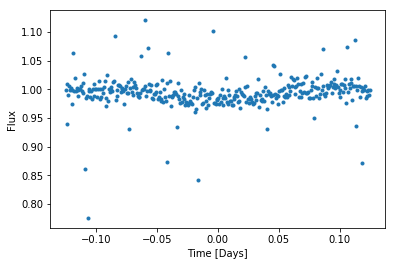

In [5]:
# Lets create a lightcurve with outliers for our smoothing
lc = LightCurveSimulator.ShortTransit()
lc.add_noise(100)
lc.add_outliers(0.1, 0.1)
lc.plotlc()
t, f, e = lc.getdata()

### Savitzky-Golay

This is a kind of filter that fits polynomials locally to the data. It can be used to smooth data. See the [scipy implimentation](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html).

In [7]:
from scipy.signal import savgol_filter
interp_savgol = savgol_filter(f, window_length=11, polyorder=3)
#windowlength is the length of the window over which the polynomial will be fit, polyorder is the order of the polynimial to be fit

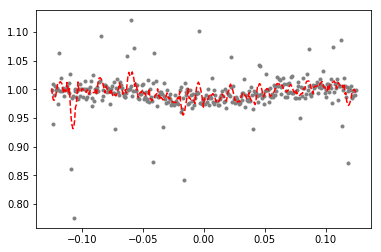

In [8]:
pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(t, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')

### Splines

[Splines](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.spline.html) are commonly used to interpolate data. They allow you to describe data in ranges not covered by the data itself (in case of gaps...)

/Users/cv307/anaconda2/envs/astroconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


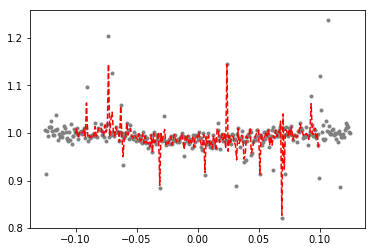

In [9]:
tnew = numpy.arange(-0.1, 0.1, 0.001)
newfl = interpolate.spline(t, f, tnew)
pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(tnew, newfl, ls='--', c='r', label='Spline')

### Median filters

The median filter can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html). Example code is shown below.

In [10]:
from scipy.signal import medfilt

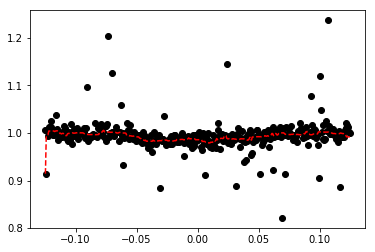

In [11]:
testfil = medfilt(f, kernel_size=21) ##kernel_size is the size of the window over which the median is calculated 
pylab.plot(t, f, c='k', ls='None', marker='o', label='Data')
pylab.plot(t, testfil, ls='--', c='r', label='Median Filter')

### Fitting models

#### General least square fitting
You can use [scipy.otimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for fitting data. It works as follows:

In [12]:
#First, define a function, the x value needs to be the first parameter to the function
#the function needs to return f(x)
def func(x, a, b, c):
    return a * numpy.exp(-b * x) + c

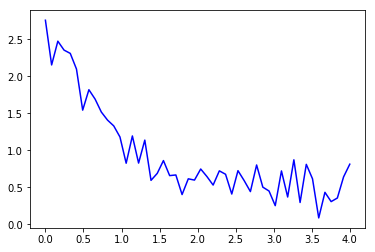

In [13]:
### Create some test data to fit
xdata = numpy.linspace(0, 4, 50) #getting the x values
y = func(xdata, 2.5, 1.3, 0.5) #getting the x values
y_noise = 0.2 * numpy.random.normal(size=xdata.size) #adding some noise
ydata = y + y_noise
yerror = numpy.ones_like(xdata) * 0.2 #this was the uncertainty 
pylab.plot(xdata, ydata, 'b-', label='data')

In [14]:
##Now fit the data. 
popt, pcov = curve_fit(func, xdata, ydata, sigma=yerror)

#### Note: You can also pass the curve_fit function a starting value as p0=[1,2,3]. This may be useful if you suspect being stuck in a local minimum.

In [15]:
##popt is your best fit
popt

array([2.36087679, 1.19712534, 0.44552035])

In [16]:
#pcov is the covariance matric
pcov

array([[ 0.01300055,  0.00478074, -0.00093293],
       [ 0.00478074,  0.01735145,  0.00565483],
       [-0.00093293,  0.00565483,  0.00315906]])

In [17]:
#The square root of the diagonal is the uncertainty on the fit
numpy.sqrt(numpy.diag(pcov))

array([0.11401997, 0.13172489, 0.0562055 ])

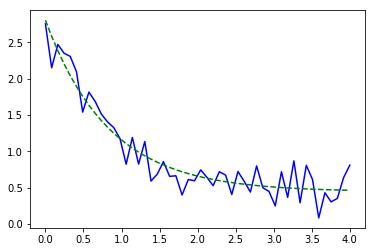

In [18]:
#plotting everything
pylab.plot(xdata, ydata, 'b-', label='data')
pylab.plot(xdata, func(xdata, *popt), 'g--',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

### Residuals

Once we have performed a fit, inspecting the residuals can be extremely useful to see regions in which the model does not fit the data well. If you spot any clear structure in the residual, that can be a sign that you need to increase the complexeity of your model.

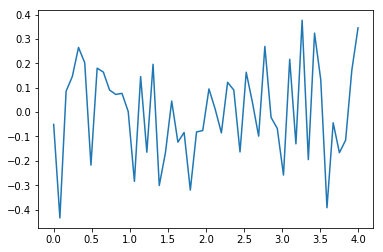

In [19]:
pylab.plot(xdata, ydata-func(xdata, *popt))

### Calculating chi-squared

We have learned that calculating chi-squared is used to measure the goodness of fit and compare models. Below is a function for you.

In [20]:
def chisquared(y, error, ymodel):
    return numpy.sum((y-ymodel)**2/error**2)
    

In [21]:
##Let's try this out on our model fit.
chisquared(ydata, yerror, func(xdata, *popt))

46.12246653505831

What is our degree of freedom $\nu$? This is the number of data points minus number of free paramaters in the fit - 1:

In [22]:
len(xdata) - 3 -1 ## number of data points

46

In [23]:
### Therefore, the reduced chi-squared is:
chisquared(ydata, yerror, func(xdata, *popt)) / (len(xdata) - 3 -1)

1.0026623159795285

### Polynimial fit

If you want to fit a polynonial, python has a custom function [numpy.polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)

### Masking arrays

In some cases, you might want to consider only a subset of the data. Some code is given below.

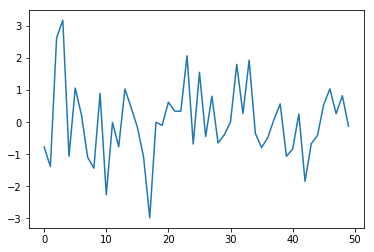

In [24]:
xtest = numpy.arange(50)
ytest = numpy.random.standard_normal(size=50)
pylab.plot(xtest, ytest)

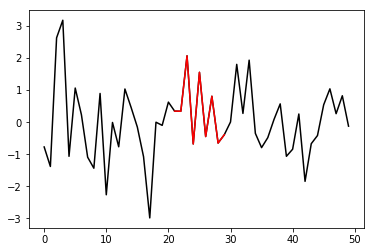

In [25]:
## Choosing only the data between x=20-30
xmask2030 = (xtest > 20) & (xtest < 30)
pylab.plot(xtest, ytest, c='k')
pylab.plot(xtest[xmask2030], ytest[xmask2030], c='r')

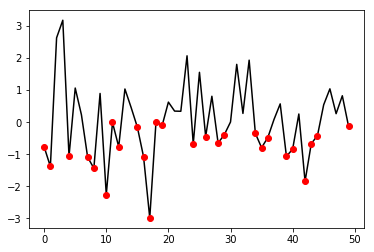

In [26]:
### Choosing only data where the y value is negative
yneg = (ytest < 0)
pylab.plot(xtest, ytest, c='k')
pylab.plot(xtest[yneg], ytest[yneg], c='r', ls='None', marker='o')

### Identifying periodicities

There are a number of functions to identify periodicties, we recommend [scipy.signal.lombscargle](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle) which works also for unevenly sampled data. This of course is very common in astrophysics.

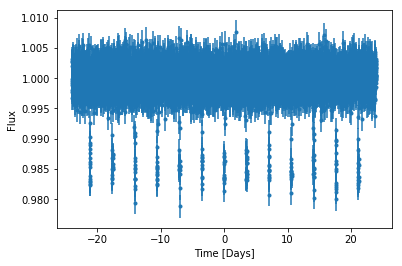

In [27]:
## Let's look at a long lightcurve with some error
lclong = LightCurveSimulator.LongLightcurve()
lclong.add_noise(sn=500)
lclong.plotlc_error()
t, f, e = lclong.getdata()

Click yourself to the [scipy.signal.lombscargle description](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle). You will see that we will need the frequencies. We have the time on the y-axis, of ~50 (days), with the shortest samplin of:  

In [28]:
t[1] - t[0]

0.0069444444961845875

In [29]:
t[-1]-t[0]

47.993055913131684

Let's get a periodogram to cover this range of timescales. Therefore, our frequencies are:

In [30]:
freqs = numpy.linspace((1/45.),(1/0.007), 1000)
import scipy.signal
from scipy.signal import lombscargle
lomb = scipy.signal.lombscargle(t, f, freqs, precenter=True)

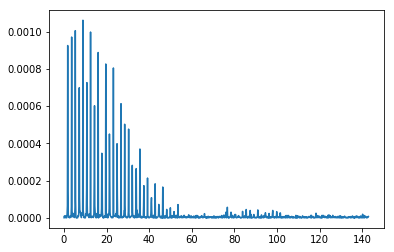

In [31]:
pylab.plot(freqs, lomb)

What happened?

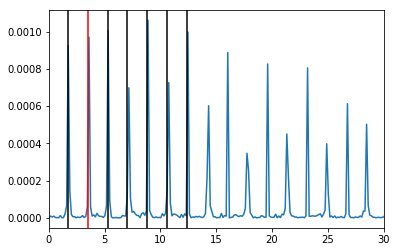

In [32]:
pylab.plot(freqs, lomb)
pylab.xlim(0,30)
actper = 3.52474859 ## the actual period
pylab.axvline(actper, c='r') ## indicating the actual period
for i in [0.5, 1.5, 2, 2.5, 3,3.5]:
    pylab.axvline(actper*i, c='k')


This is known as aliasing, we will discuss the issues of interpreting such periodograms. A paper discussing it's meaning can be found [here](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract). 

### Folding your lightcurve

If you have long lightcurves, you may have to fold them, i.e. shift them by the period so you can see a more detailed view of an individual transit. Below is some code to do so, courtsey of Victoria Scowcroft.

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def fold_lightcurve(filename, period, *args, **kwargs):
    obj_name = kwargs.get('obj_name', None)
    outdata = kwargs.get('output_file', 'folded_lc_data.csv')
    plotname = kwargs.get('plot_file', 'folded_lc.pdf')
    
    ## Read in the data. Should be comma separated, header row (if present) should have # at the start.
    data = pd.read_csv(filename, usecols=[0,1,2], names=('JD', 'mag', 'error'), comment='#')
    if len(data.columns) < 3:
        print("File format should be \n\
              (M)JD, magnitude, uncertainty\n")
        exit(1)
    ## Folding the lightcurve:
    ## Phase = JD/period - floor(JD/period)
    ## The floor function is there to make sure that the phase is between 0 and 1.
    
    data['Phase'] = data.apply(lambda x: ((x.JD/ period) - np.floor(x.JD / period)), axis=1)
    
      
    ## Now make the plot
    
    plt.clf()
    plt.figure(figsize=(10,5))
    
    ## concatenating the arrays to make phase -> 0 - 3
    ## This makes it easier to see if periodic lightcurves join up as expected
    
    phase_long = np.concatenate((data.Phase, data.Phase + 1.0, data.Phase + 2.0))
    mag_long = np.concatenate((data.mag, data.mag, data.mag))
    err_long = np.concatenate((data.error, data.error, data.error))
    
    plt.errorbar(phase_long, mag_long, yerr=err_long, marker='o', ls='None', zorder=4, label='_nolegend_', mec='Grey')
    ## Inverting the y axis because magnitudes
    plt.gca().invert_yaxis()
    
    plt.xlabel('Phase ($\phi$)')
    plt.ylabel('Magnitude')
    
    ## making the plot title to include object and period. 
    ## If no object name given in kwargs then title is just period
    if obj_name != None:
        namestring = str(obj_name) + ', '
    else:
        namestring = ''
    titletext = namestring + 'P = ' + str(np.around(period, decimals=4)) + 'd'
    plt.suptitle(titletext)
    
    plt.savefig(plotname)
    
    ## Printing the phased data to a csv file.
    ## If filename not given in fold_lightcurve arguments default filename is folded_lc_data.csv
    
    data.to_csv(outdata, header=True, index=False, sep=',')

    
    return data


In [39]:
### Let's try this out on our lightcurve with the period derived.
# We'll first need to write our data to file.
numpy.savetxt('dummylc.csv', numpy.array([t, f, e]).transpose(), header='#JD, mag, error', delimiter=',')


<Figure size 432x288 with 0 Axes>

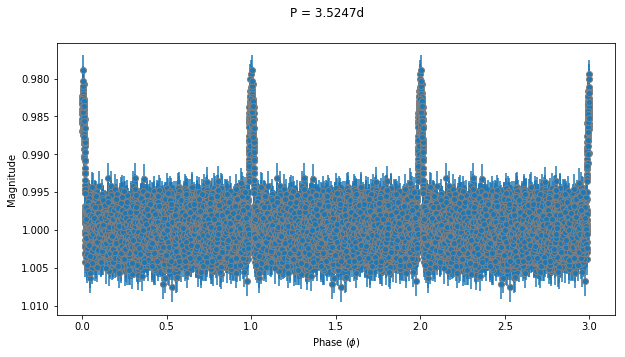

In [40]:
## This planet has a period of 3.52474859
tmp=fold_lightcurve('dummylc.csv', 3.52474859)
#Phase goes from 0-1, we can clear see a nicely folded transit for this phase

In [41]:
tmp

,JD,mag,error,Phase
0,-23.996528,0.999251,0.001999,0.191989
1,-23.989584,1.002007,0.002004,0.193959
2,-23.982639,0.996701,0.001993,0.195929
3,-23.975695,0.998016,0.001996,0.197899
4,-23.968750,0.997735,0.001995,0.199870
5,-23.961806,1.002904,0.002006,0.201840
6,-23.954861,1.003139,0.002006,0.203810
7,-23.947917,0.998816,0.001998,0.205780
8,-23.940972,0.999833,0.002000,0.207750
9,-23.934028,0.999599,0.001999,0.209721
